<a href="https://colab.research.google.com/github/mufadluqman/Time-Series-Analysis-and-Forecasting-of-IDX-Composite-Index-IHSG-Based-on-ARIMA-and-ETS-Model/blob/main/Time_Series_Analysis_and_Forecasting_of_IDX_Composite_Index_(IHSG)_Based_on_ARIMA_and_ETS_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Time Series Analysis and Forecasting of IDX Composite Index (IHSG)**


**IDX Composite/Indeks Harga Saham Gabungan (IHSG)**

An index that measures the stock price performance of all listed companies in Main Board and Development Board of the Indonesia Stock Exchange.

**Objectives**
- Forecasting the IDX Composite/Indeks Harga Saham Gabungan (IHSG) level for the following year.
- Determining the best performance in forecasting, in this project between the ARIMA model and the ETS Model.

**Model**
- ARIMA (Autoregressive Integrated Moving Average)
- ETS (Exponential Smoothing)

**Dataset**

The data is sourced from Yahoo Finance and compiled by Gareth Aurelius Harrison. The data can be downloaded via this link: [Kaggle](https://www.kaggle.com/datasets/garethharrison/daily-ihsg/data)

**Note:** This analysis is not intended as financial advice; it is for informational purposes only in the application of scientific studies that are expected to provide perspectives related to predictions or forecasts of the IDX Composite/Indeks Harga Saham Gabungan (IHSG) Level.

In [49]:
!pip install pmdarima
import pmdarima as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot as qq
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose as sd
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import itertools
import statsmodels.api as sm


# **Loading Data**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/ihsg_daily.csv', index_col='Date', parse_dates=['Date'])
series = df['Close']
df.head()

,Close,High,Low,Open
Date,,,,
1995-01-02,470.121735,470.121735,470.121735,470.121735
1995-01-03,472.361633,472.361633,472.361633,472.361633
1995-01-04,474.471527,474.471527,474.471527,474.471527
1995-01-05,477.801422,477.801422,477.801422,477.801422
1995-01-06,481.201263,481.201263,481.201263,481.201263


**Data Description:**

**Date:** Trading date for the Jakarta Composite Index (IHSG).

**Open:** Opening level of the IHSG index at the
start of the trading day.

**High:** Highest level reached by the IHSG index during the trading day.

**Low:** Lowest level reached by the IHSG index during the trading day.

**Close:** Closing level of the IHSG index at the end of the trading day.

### **Summary Statistics**

In [4]:
df.describe()

,Close,High,Low,Open
count,7486.000000,7486.000000,7486.000000,7486.000000
mean,3254.782823,3273.411189,3234.235363,3255.135871
std,2487.921178,2500.587193,2476.075819,2489.317030
min,256.824036,261.303830,255.454079,257.513955
25%,618.008392,621.869823,613.702872,617.761178
50%,2829.974487,2847.447524,2797.120268,2830.076974
75%,5606.721070,5641.965820,5575.141601,5599.731445
max,8139.894043,8176.308105,8104.551758,8161.284180


# **Data Preprocessing**

**Checking Null Values**

In [5]:
df.isnull().sum()

,0
Close,0
High,0
Low,0
Open,0


**Checking Duplicate Data**

In [6]:
df.duplicated().sum()

np.int64(7)

In [8]:
df = df.drop_duplicates()
df.duplicated().sum()

np.int64(0)

**Visualization**

/usr/local/lib/python3.12/dist-packages/pandas/plotting/_matplotlib/core.py:975: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  return ax.plot(*args, **kwds)
/usr/local/lib/python3.12/dist-packages/pandas/plotting/_matplotlib/core.py:975: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  return ax.plot(*args, **kwds)
/usr/local/lib/python3.12/dist-packages/pandas/plotting/_matplotlib/core.py:975: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  return ax.plot(*args, **kwds)
/usr/local/lib/python3.12/dist-packages/pandas/plotting/_matplotlib/core.py:975: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  return ax.plot(*args, **kwds)


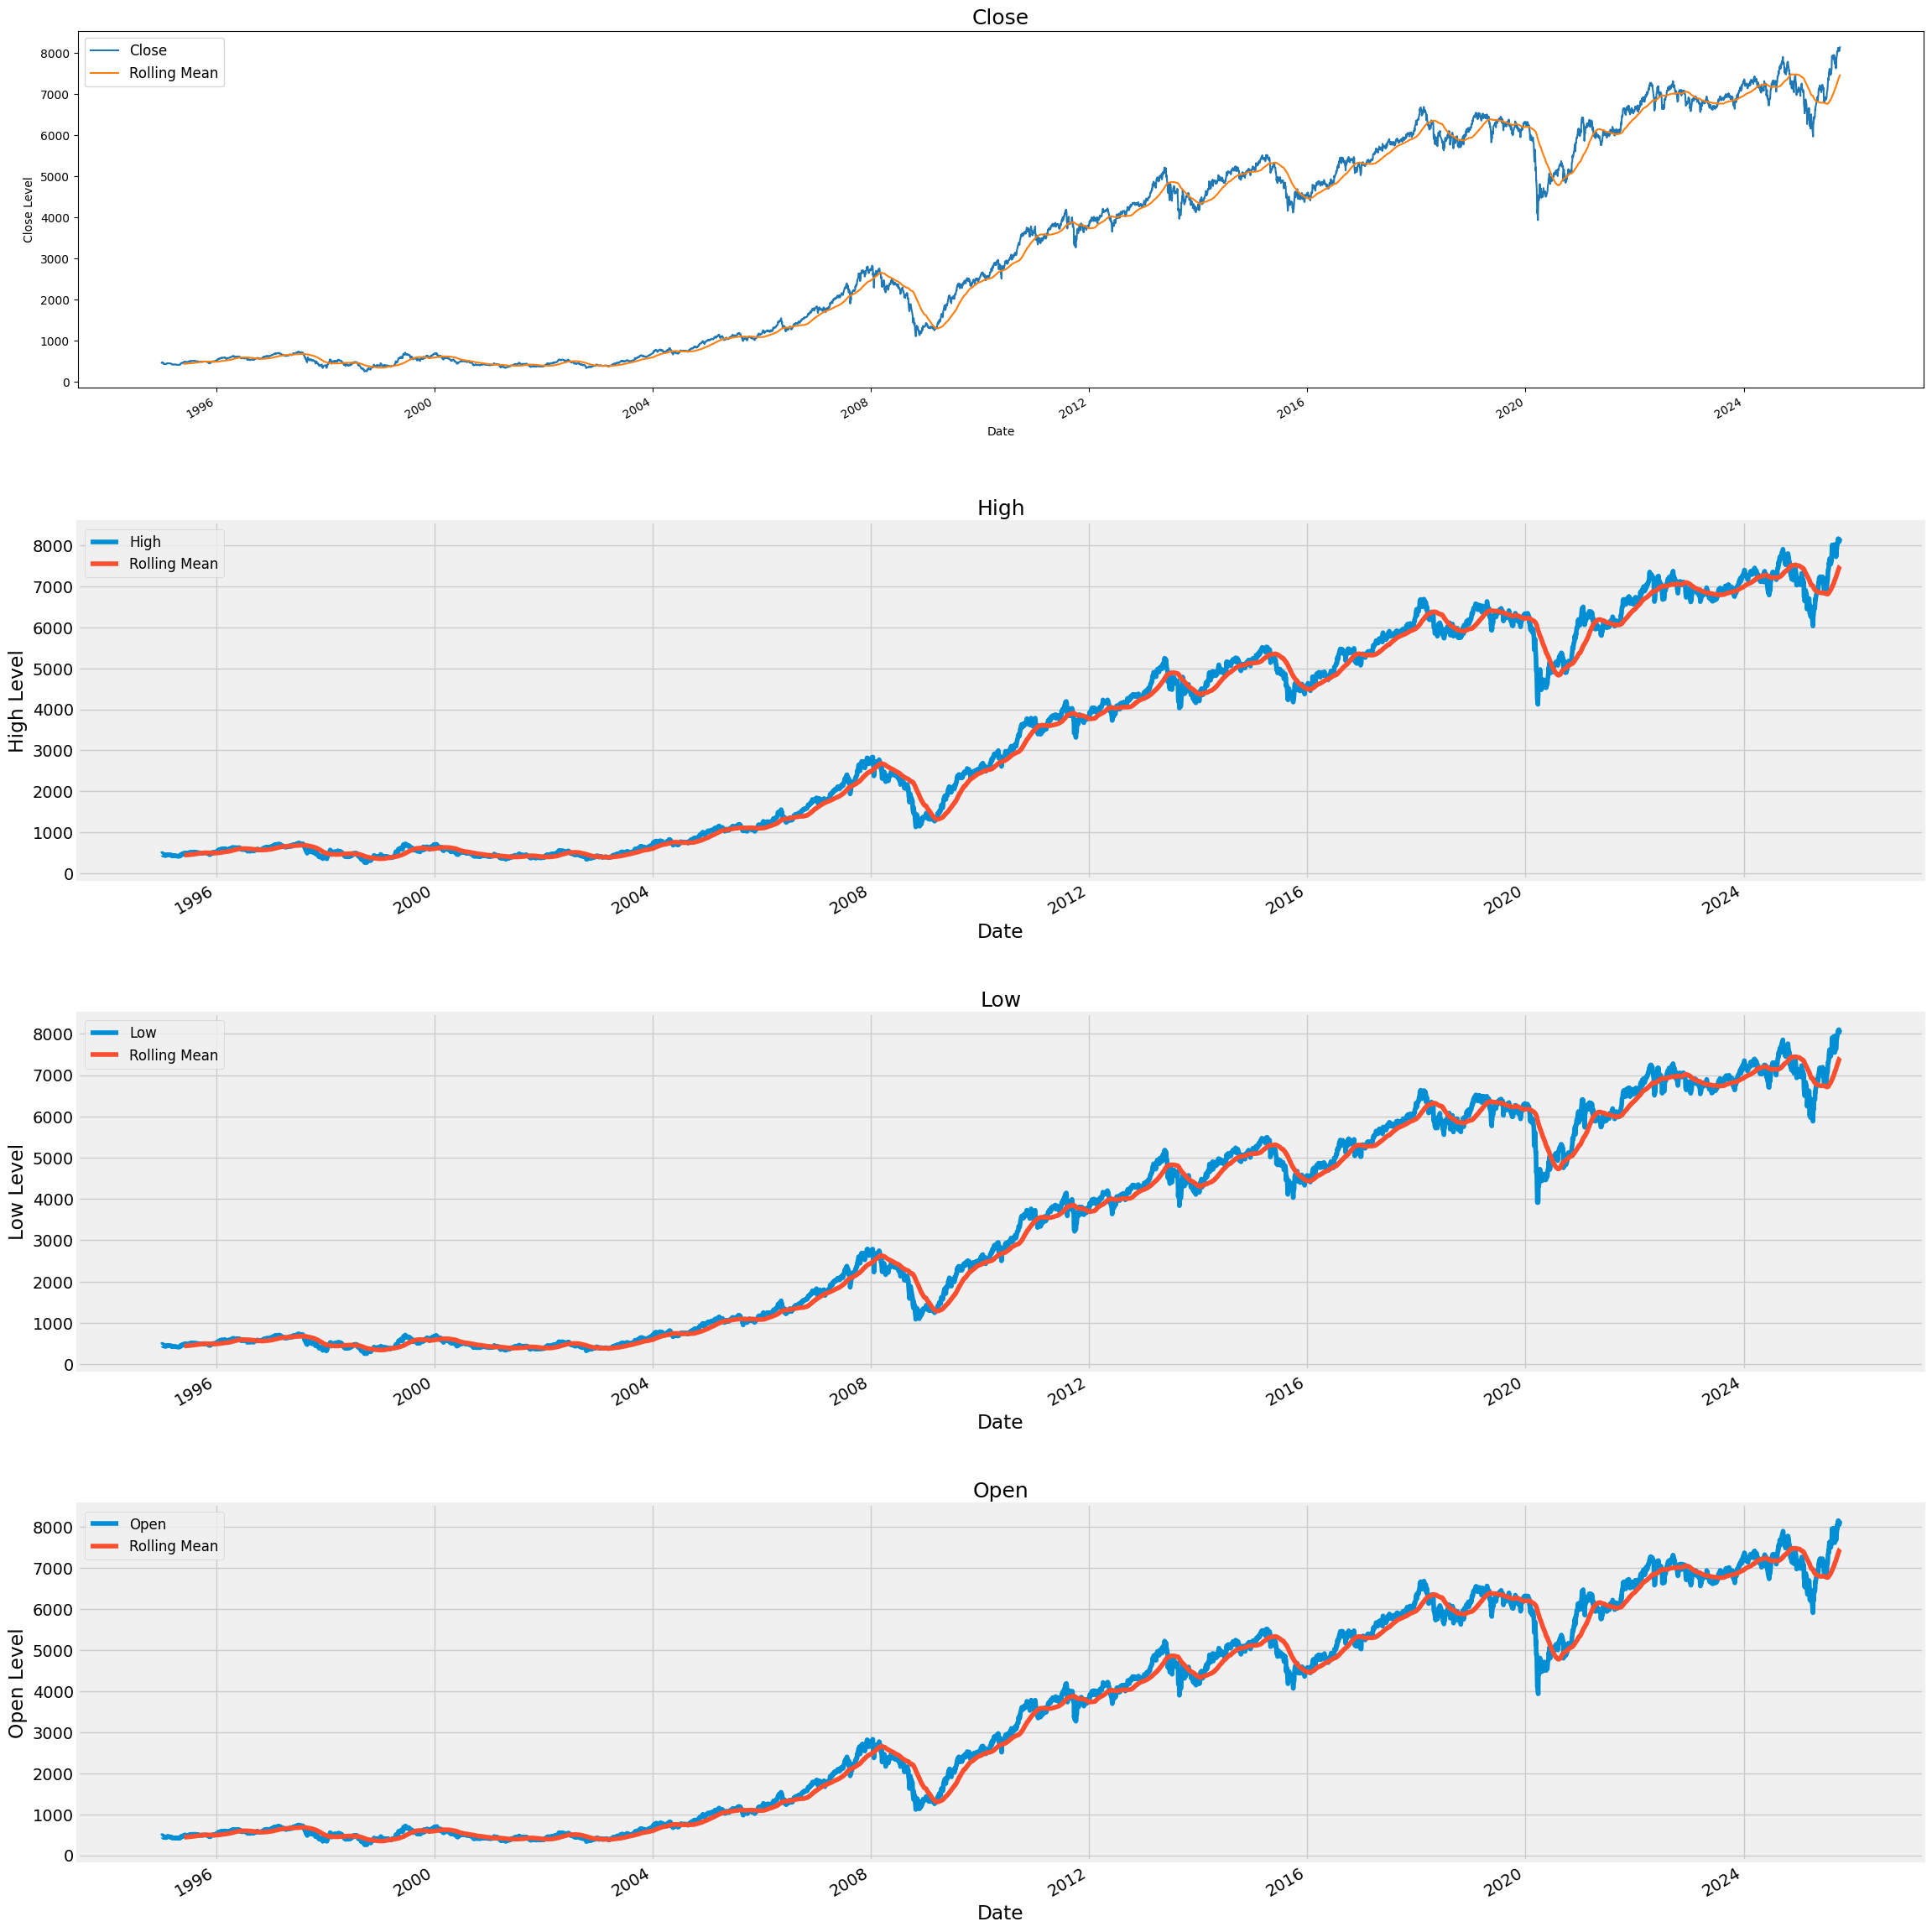

In [9]:
col_names = df.columns

fig = plt.figure(figsize=(24, 24))
for i in range(len(col_names)):
  ax = fig.add_subplot(len(col_names),1,i+1)
  ax.plot(df.iloc[:,i],label=col_names[i])
  df.iloc[:,i].rolling(100).mean().plot(label='Rolling Mean')
  ax.set_title(col_names[i],fontsize=18)
  ax.set_xlabel('Date')
  ax.set_ylabel(f'{col_names[i]} Level')
  ax.patch.set_edgecolor('black')
  plt.style.context('fivethirtyeight')
  plt.legend(prop={'size': 12})
  plt.style.use('fivethirtyeight')

fig.tight_layout(pad=3.0)
plt.show()

# **Features Selection**
We can automatically remove features like Open, Low, and High because they have high multicollinearity with Close. We consider Close as the target variable.

**HeatMap to Verify Multicollinearity between Features**

/tmp/ipython-input-2779384859.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


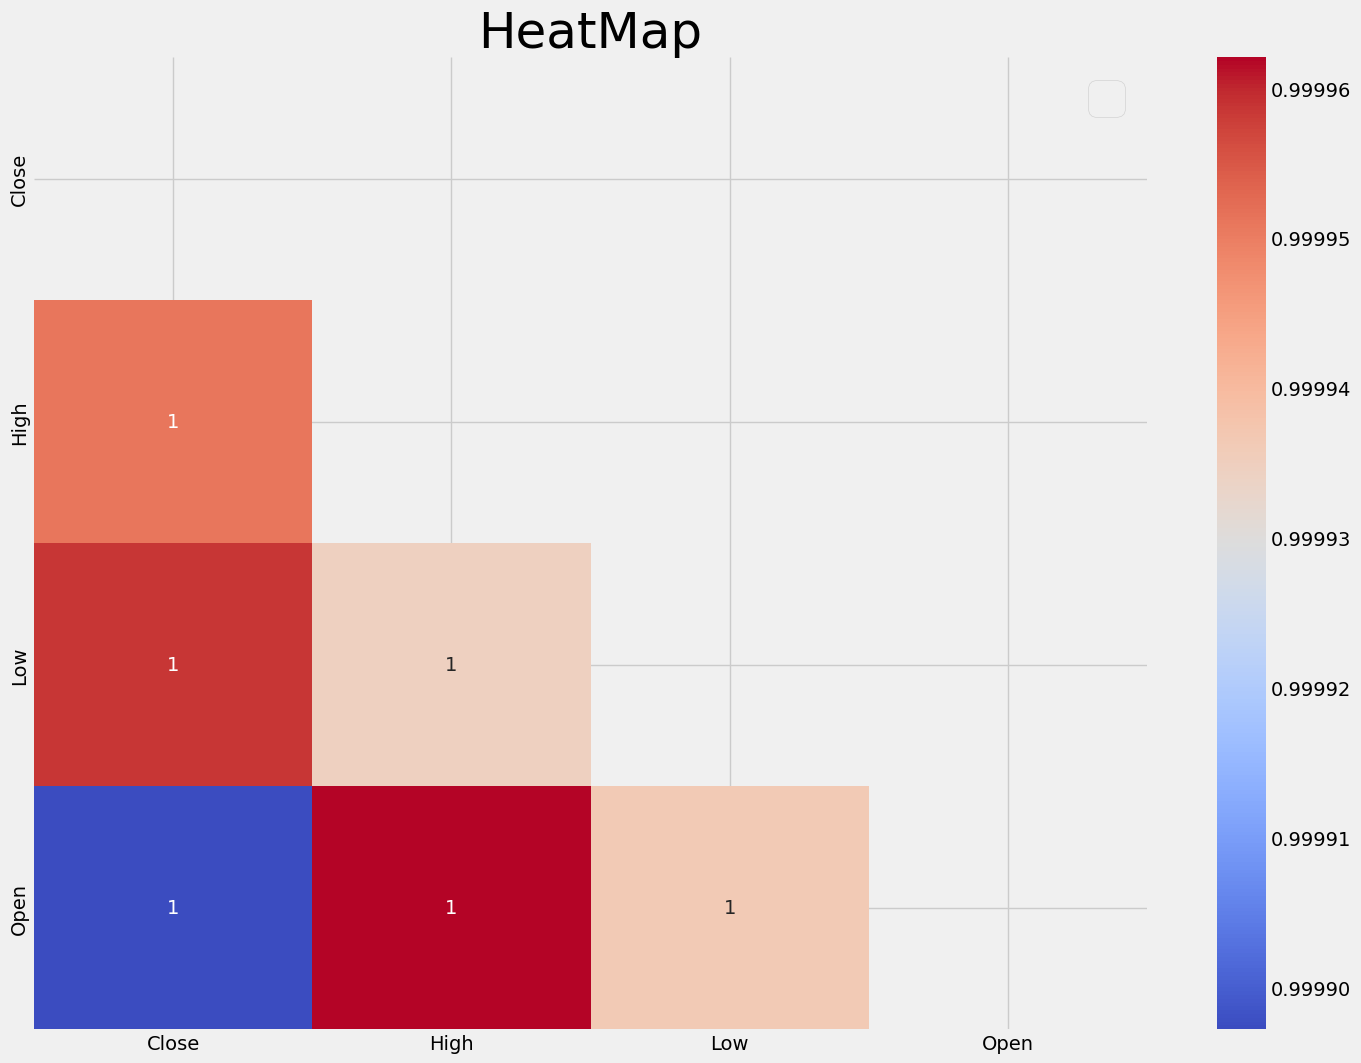

In [10]:
fig = plt.figure(figsize=(16, 12))
matrix = np.triu(df.corr())
ax = sns.heatmap(df.corr(),annot=True,annot_kws={"size":14},mask=matrix,cmap='coolwarm')
ax.tick_params(labelsize=14)
sns.set(font_scale=3)
ax.set_title('HeatMap')
plt.style.use('fivethirtyeight')
plt.legend()
plt.show()

**Data after Features Selection**

In [11]:
data_feature_selected = df.drop(axis=1, labels=['Open','High','Low'])

In [12]:
col_order = ['Close']
data_feature_selected = data_feature_selected.reindex(columns=col_order)
data_feature_selected

,Close
Date,
1995-01-02,470.121735
1995-01-03,472.361633
1995-01-04,474.471527
1995-01-05,477.801422
1995-01-06,481.201263
...,...
2025-09-30,8061.062012
2025-10-01,8043.821777
2025-10-02,8071.081055


# **Resampling**
Resample Data to Monthly instead of Daily by Aggregating Using Mean

In [13]:
monthly_mean = data_feature_selected['Close'].resample('M').mean()

/tmp/ipython-input-3587160852.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_mean = data_feature_selected['Close'].resample('M').mean()


In [14]:
monthly_data = monthly_mean.to_frame()
monthly_data

,Close
Date,
1995-01-31,453.124637
1995-02-28,452.030829
1995-03-31,430.561668
1995-04-30,421.273600
1995-05-31,450.901928
...,...
2025-06-30,7038.140625
2025-07-31,7214.084558
2025-08-31,7763.641797


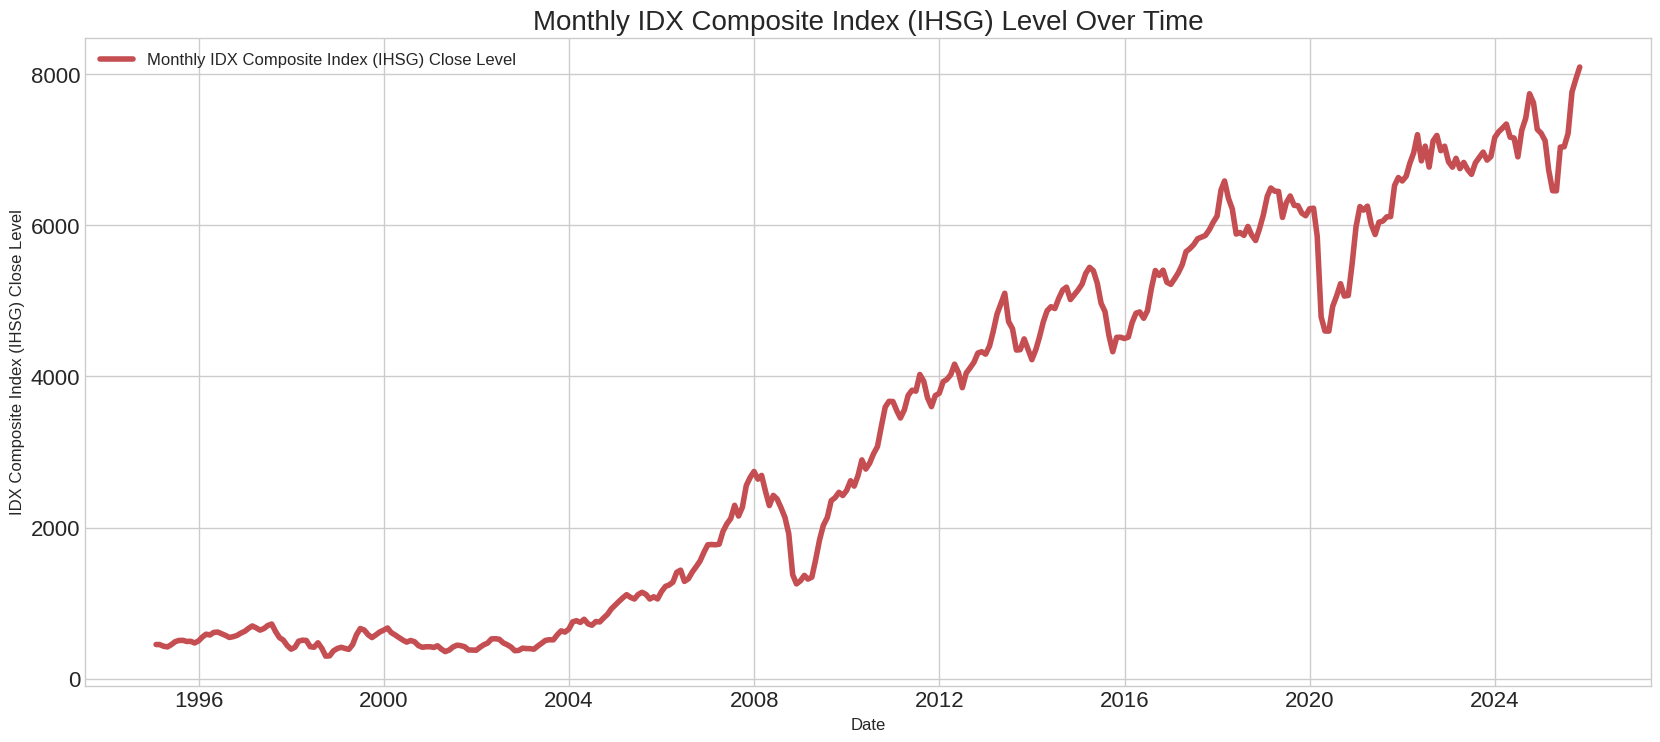

In [100]:
fig = plt.figure(figsize=(18,8))
plt.plot(monthly_data['Close'],label='Monthly IDX Composite Index (IHSG) Close Level', color='r')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('Monthly IDX Composite Index (IHSG) Level Over Time', fontsize=20)
plt.xlabel('Date')
plt.ylabel('IDX Composite Index (IHSG) Close Level')
plt.style.use('fivethirtyeight')
plt.legend(prop={'size': 12})
plt.show()

# **Exploratory Data Analysis (EDA)**

### **Raw Data**

**Distribution Data and Box Plot Data**

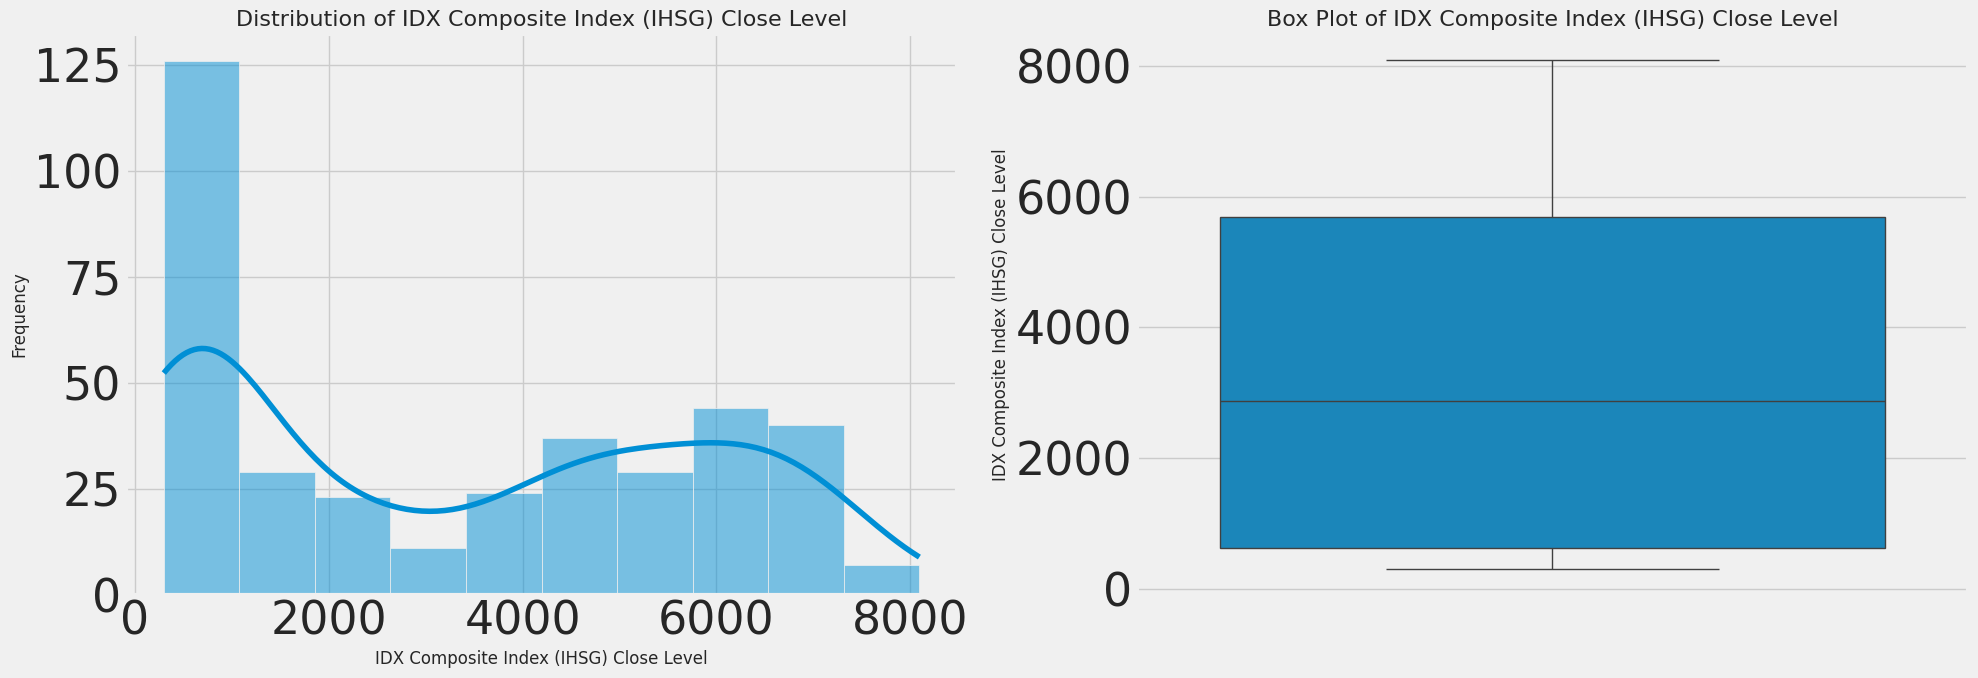

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(20, 7))

sns.histplot(monthly_data['Close'], kde=True, ax=axes[0])
axes[0].set_title('Distribution of IDX Composite Index (IHSG) Close Level', fontsize=16)
axes[0].set_xlabel('IDX Composite Index (IHSG) Close Level', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)

sns.boxplot(y=monthly_data['Close'], ax=axes[1])
axes[1].set_title('Box Plot of IDX Composite Index (IHSG) Close Level', fontsize=16)
axes[1].set_ylabel('IDX Composite Index (IHSG) Close Level', fontsize=12)

plt.tight_layout()
plt.show()

**Distribution Plot Inference:** Distribution shows Right Skew

**Box-Plot Inference:**

* Distribution shows a rightward skew
* Outliers approach the upper limit around the 8000 index level

**Q-Q Plot IDX Composite Index (IHSG)**

Text(0.5, 1.0, 'Q-Q Plot IDX Composite Index (IHSG)')

<Figure size 1200x800 with 0 Axes>

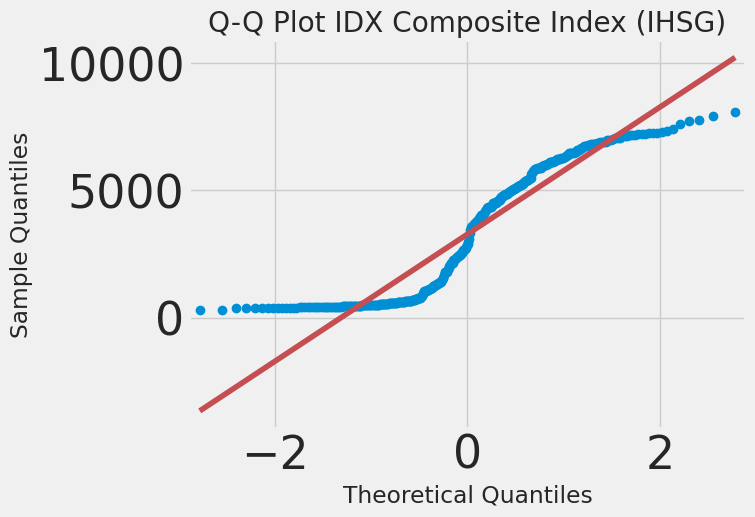

In [27]:
plt.figure(figsize=(12,8))
qq_plot = qq(monthly_data['Close'],line='s')
plt.title('Q-Q Plot IDX Composite Index (IHSG)')

**QQ Plot Inference:**

* Heavy-Tailed Distribution - Curve at the End
* Shows the extent of skewness on the right and left
* Shows the Distribution Does Not Follow a Gaussian Normal Distribution

### **Decomposition**

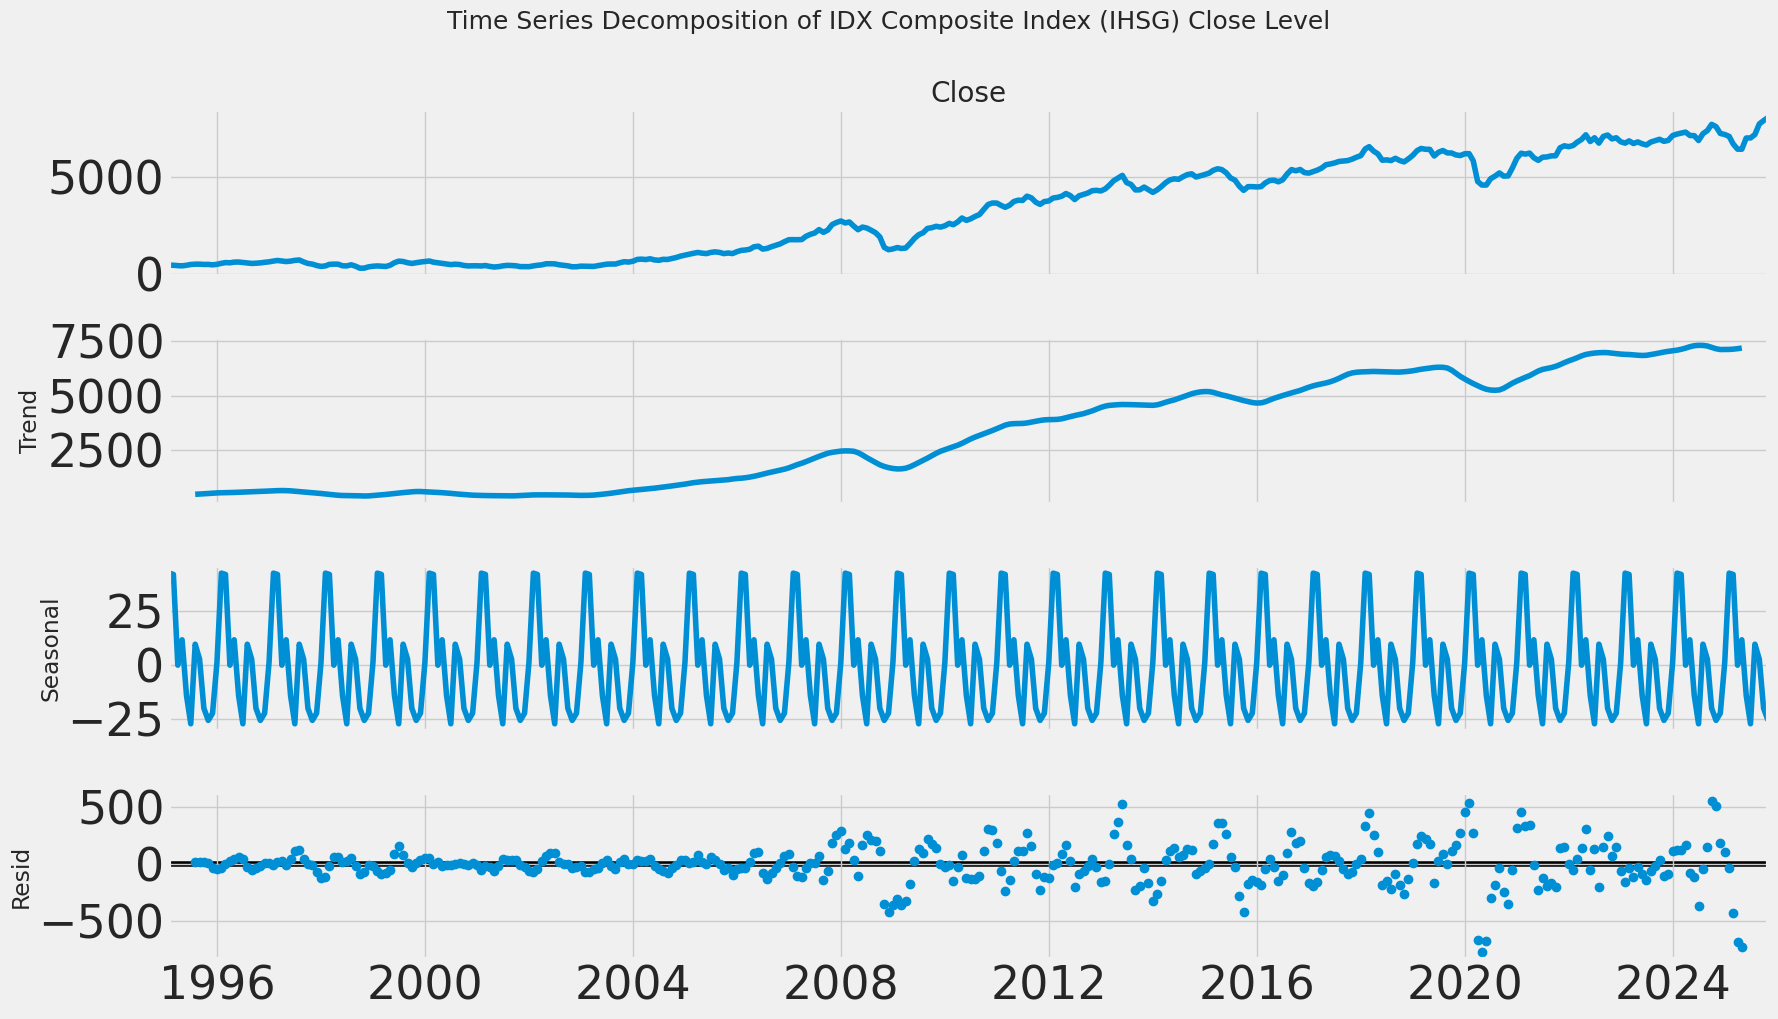

In [34]:
plt.rcParams['figure.figsize'] = (18, 10)
decomposed_series = sd(monthly_data['Close'], model='additive', period=12)
fig = decomposed_series.plot()
fig.suptitle('Time Series Decomposition of IDX Composite Index (IHSG) Close Level',
             fontsize=18, y=1.02)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

**Inference Based on Decomposition:**

*   **Trend:** Overall Upward Trend
*   **Seasonality:** There appears to be seasonality; the IHSG consistently strengthens in the months from Q3 to Q4. This could be due to corporate actions related to company shares.

### **Stationarity**
Stationarity means that the statistical properties of a time series i.e. mean, variance and covariance do not change over time. Many statistical models require the series to be stationary to make effective and precise predictions.
Two statistical tests would be used to check the stationarity of a time series – Augmented Dickey Fuller (“ADF”) test and Kwiatkowski-Phillips-Schmidt-Shin (“KPSS”) test. A method to convert a non-stationary time series into stationary series shall also be used.

**ADF Test**

Null Hypothesis : Time series has a unit root.

Alternate Hypothesis : Time series does not have a unit root.

- p-value ≤ 0.05 → Reject H0 → Data is stationary
- p-value > 0.05 → Fail to reject H0 → Data is non-stationary

In [35]:
def ad_fuller_func(X):
  result_ad_fuller = adfuller(X)
  print('ADF Statistic: %f' % result_ad_fuller[0])
  print('p-value: %f' %result_ad_fuller[1])
  print('Critical Values:')
  for key, value in result_ad_fuller[4].items():
	  print('\t%s: %.3f' % (key, value))

  if result_ad_fuller[0] < result_ad_fuller[4]['5%']:
    print('Reject Null Hypothesis(Ho)-Time Series is Stationary')
  else:
    print('Failed to Reject Ho-Time Series is Non-Stationary')

ad_fuller_func(monthly_data['Close'])

ADF Statistic: 0.442792
p-value: 0.983027
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571
Failed to Reject Ho-Time Series is Non-Stationary


**Non-stationary** time series as observed previously also through decomposition (there are **trend** and **seasonality**). Statistically verified through the ADF test

**Autocorrelation Function (ACF)**



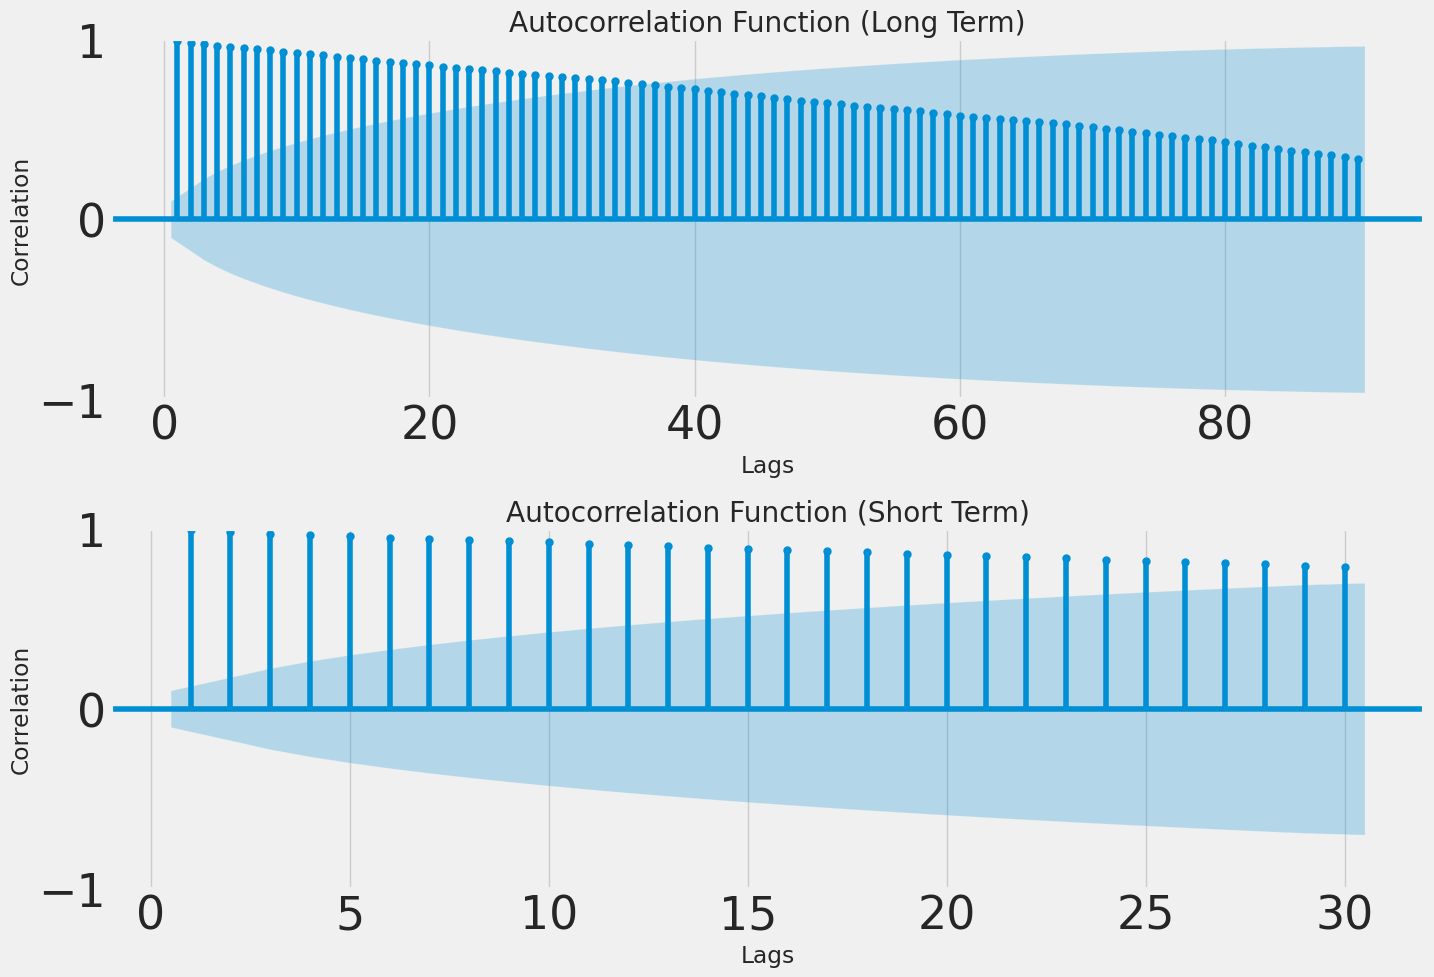

In [38]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# ACF Long Term
plot_acf(monthly_data['Close'], lags=90, ax=ax1, zero=False)
ax1.set_title("Autocorrelation Function (Long Term)")
ax1.set_xlabel("Lags")
ax1.set_ylabel("Correlation")

# ACF Short Term
plot_acf(monthly_data['Close'], lags=30, ax=ax2, zero=False)
ax2.set_title("Autocorrelation Function (Short Term)")
ax2.set_xlabel("Lags")
ax2.set_ylabel("Correlation")

plt.tight_layout()
plt.show()

**Partial Autocorrelation Function (PACF)**

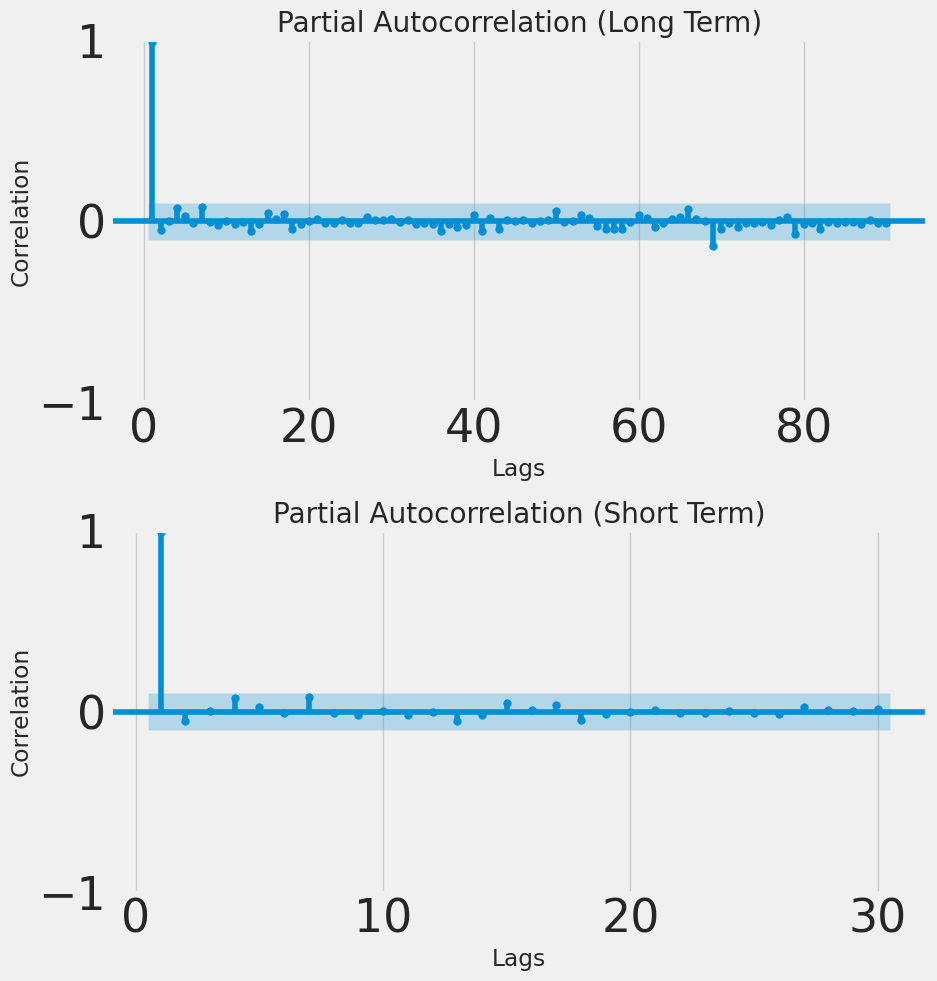

In [41]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# PACF Long Term
plot_pacf(monthly_data['Close'], lags=90, ax=ax1, zero=False)
ax1.set_title("Partial Autocorrelation (Long Term)")
ax1.set_xlabel("Lags")
ax1.set_ylabel("Correlation")

# PACF Short Term
plot_pacf(monthly_data['Close'], lags=30, ax=ax2, zero=False)
ax2.set_title("Partial Autocorrelation (Short Term)")
ax2.set_xlabel("Lags")
ax2.set_ylabel("Correlation")

plt.tight_layout(pad=1)
plt.show()

*   **ACF** results show that the autocorrelation value is very high at many lags and decreases slowly, which means that the IHSG data is highly non-stationary and has random walk characteristics, so differencing is needed to make it stationary.

*   **PACF** only shows a large spike at lag 1, while other lags are insignificant, indicating that after differencing, the data will follow an AR(1) pattern, so the indicated model is ARIMA with an AR component at lag 1.



# **ARIMA Model**

In [43]:
arimamodel_series = monthly_data['Close']
arimamodel_series

,Close
Date,
1995-01-31,453.124637
1995-02-28,452.030829
1995-03-31,430.561668
1995-04-30,421.273600
1995-05-31,450.901928
...,...
2025-06-30,7038.140625
2025-07-31,7214.084558
2025-08-31,7763.641797


### **Data Split**

In [44]:
train_size = int(len(arimamodel_series) * 0.8)
train, test = arimamodel_series[0:train_size], arimamodel_series[train_size:len(arimamodel_series)]
print(f'Train set size: {len(train)}')
print(f'Test set size: {len(test)}')

Train set size: 296
Test set size: 74


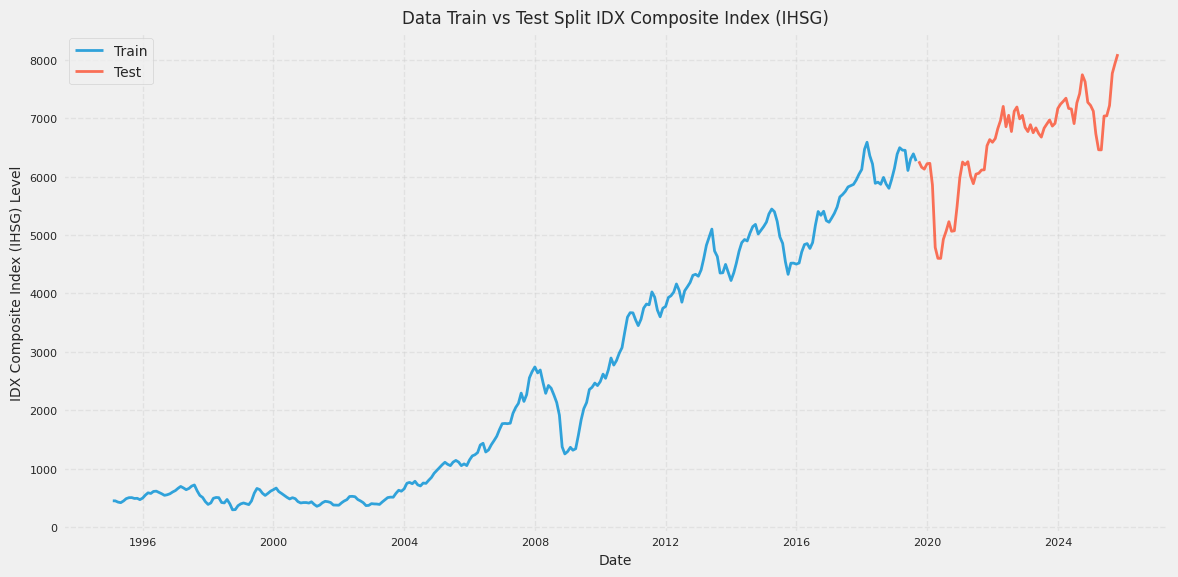

In [47]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(train, label='Train', linewidth=2, alpha=0.8)
ax.plot(test, label='Test', linewidth=2, alpha=0.8)

ax.set_title('Data Train vs Test Split IDX Composite Index (IHSG)', fontsize=12)
ax.set_xlabel('Date', fontsize=10)
ax.set_ylabel('IDX Composite Index (IHSG) Level', fontsize=10)

ax.tick_params(axis='both', labelsize=8)

ax.grid(True, linestyle='--', alpha=0.4)
ax.legend(fontsize=10)

plt.tight_layout()
plt.show()

### **Auto ARIMA**

In [62]:
import pmdarima as pm


model = pm.auto_arima(train,
                   start_p=0, start_q=0,
                   max_p=5, max_q=5,
                   seasonal=True,
                   start_P=0, start_Q=0,
                   max_P=2, max_Q=2,
                   m=12,
                   d=None, D=None,
                   trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True)

print(model.summary())
print(f"Best Model: SARIMA{model.order}x{model.seasonal_order}")

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3627.611, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3592.920, Time=0.98 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3592.417, Time=1.50 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3634.519, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=3591.772, Time=0.90 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=3592.226, Time=1.85 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=3591.888, Time=2.11 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=3593.081, Time=0.35 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=3593.244, Time=0.31 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=3592.495, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=3595.012, Time=0.56 sec
 ARIMA(0,1,1)(0,0,0)[12]             : AIC=3595.182, Time=0.17 sec

Best model:  ARIMA(0,1,1)(0,0,0)[12] intercept
Total fit time: 9.082 seconds
                               SARIMAX Results                             

### **Model Diagnostics**

In [63]:
residuals = model.resid()

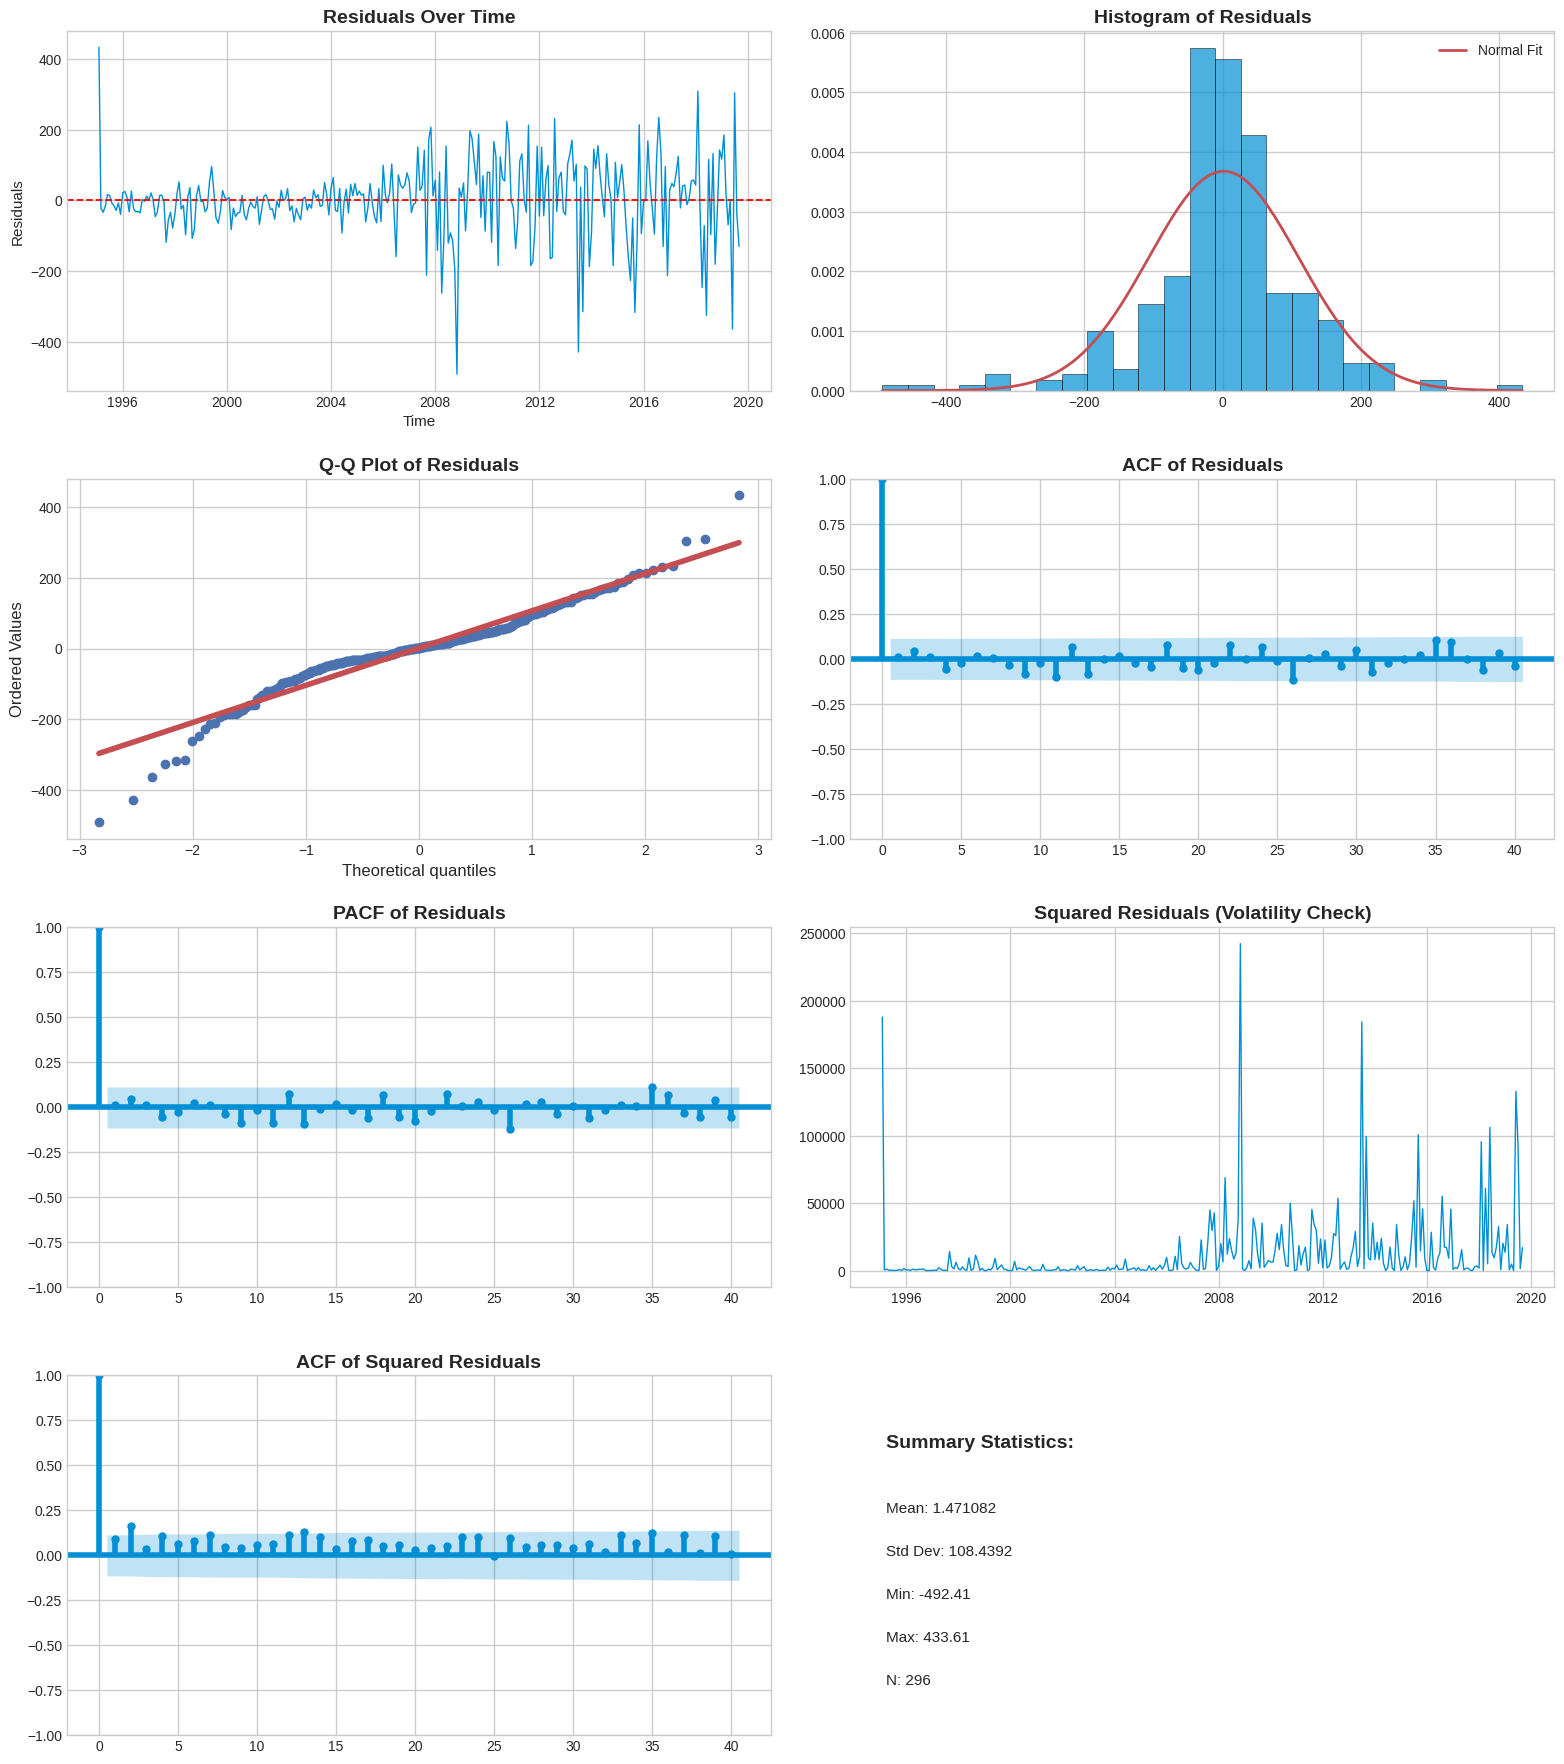

In [64]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import stats

plt.style.use("seaborn-v0_8-whitegrid")

title_size = 14
label_size = 11
tick_size = 10

fig, axes = plt.subplots(4, 2, figsize=(16, 18))
(ax1, ax2, ax3, ax4,
 ax5, ax6, ax7, ax8) = axes.flatten()

ax1.plot(residuals, linewidth=1)
ax1.axhline(0, color='red', linestyle='--', linewidth=1.3)
ax1.set_title("Residuals Over Time", fontsize=title_size, weight='bold')
ax1.set_xlabel("Time", fontsize=label_size)
ax1.set_ylabel("Residuals", fontsize=label_size)
ax1.tick_params(axis='both', labelsize=tick_size)

ax2.hist(residuals, bins=25, density=True, alpha=0.7, edgecolor='black')
mu, std = residuals.mean(), residuals.std()
x = np.linspace(residuals.min(), residuals.max(), 200)
ax2.plot(x, stats.norm.pdf(x, mu, std), 'r-', lw=2, label="Normal Fit")
ax2.set_title("Histogram of Residuals", fontsize=title_size, weight='bold')
ax2.legend(fontsize=10)
ax2.tick_params(axis='both', labelsize=tick_size)

stats.probplot(residuals, dist="norm", plot=ax3)
ax3.set_title("Q-Q Plot of Residuals", fontsize=title_size, weight='bold')
ax3.tick_params(axis='both', labelsize=tick_size)

plot_acf(residuals, lags=40, ax=ax4)
ax4.set_title("ACF of Residuals", fontsize=title_size, weight='bold')
ax4.tick_params(axis='both', labelsize=tick_size)

plot_pacf(residuals, lags=40, ax=ax5)
ax5.set_title("PACF of Residuals", fontsize=title_size, weight='bold')
ax5.tick_params(axis='both', labelsize=tick_size)

ax6.plot(residuals**2, linewidth=1)
ax6.set_title("Squared Residuals (Volatility Check)", fontsize=title_size, weight='bold')
ax6.tick_params(axis='both', labelsize=tick_size)

plot_acf(residuals**2, lags=40, ax=ax7)
ax7.set_title("ACF of Squared Residuals", fontsize=title_size, weight='bold')
ax7.tick_params(axis='both', labelsize=tick_size)

ax8.axis("off")
ax8.text(0.05, 0.80, "Summary Statistics:", fontsize=title_size, weight='bold')
ax8.text(0.05, 0.62, f"Mean: {residuals.mean():.6f}", fontsize=label_size)
ax8.text(0.05, 0.50, f"Std Dev: {residuals.std():.4f}", fontsize=label_size)
ax8.text(0.05, 0.38, f"Min: {residuals.min():.2f}", fontsize=label_size)
ax8.text(0.05, 0.26, f"Max: {residuals.max():.2f}", fontsize=label_size)
ax8.text(0.05, 0.14, f"N: {len(residuals)}", fontsize=label_size)

plt.tight_layout(pad=2.0)
plt.show()


### **Model Evaluation**


TEST SET PERFORMANCE
RMSE: 622.1699
MAE:  434.6055
MAPE: 7.48%
Excellent forecasting accuracy (MAPE < 10%)


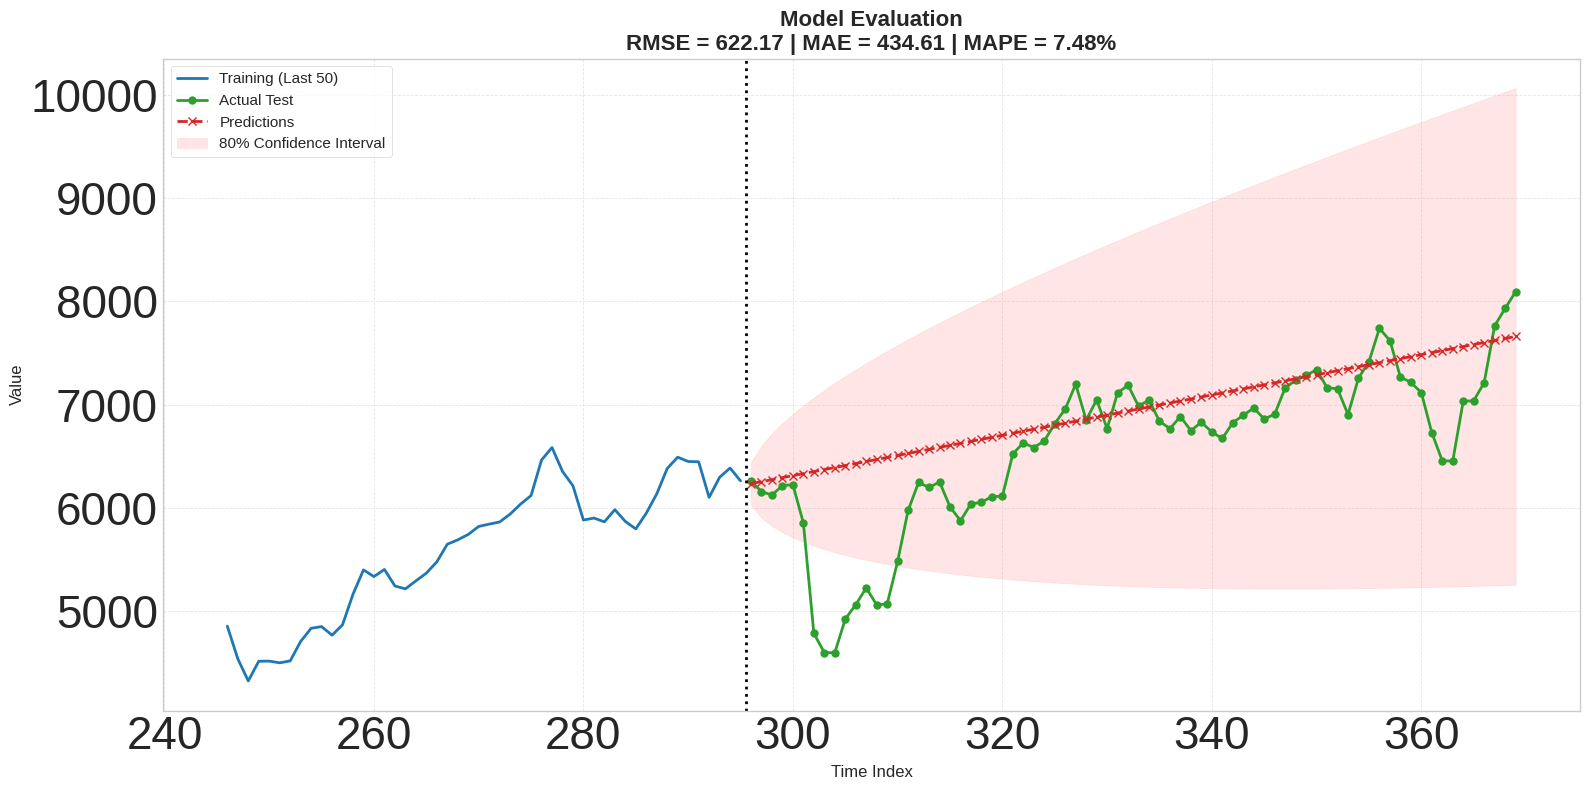

In [69]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


n_periods = len(test)
predictions = model.predict(n_periods=n_periods)

pred_with_ci = model.predict(n_periods=n_periods, return_conf_int=True, aplha=0.20)
pred_mean = pred_with_ci[0]
conf_int = pred_with_ci[1]

rmse = np.sqrt(mean_squared_error(test, predictions))
mae = mean_absolute_error(test, predictions)
mape = np.mean(np.abs((test - predictions) / test)) * 100

print("\n" + "="*80)
print("TEST SET PERFORMANCE")
print("="*80)
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print("="*80)

if mape < 10:
    print("Excellent forecasting accuracy (MAPE < 10%)")
elif mape < 20:
    print("Good forecasting accuracy (MAPE < 20%)")
elif mape < 50:
    print("Reasonable forecasting accuracy (MAPE < 50%)")
else:
    print("Poor forecasting accuracy (MAPE > 50%) - Consider improvement")

plt.figure(figsize=(16, 8))

plt.plot(train_index, train_plot,
         label='Training (Last 50)',
         color='#1f77b4', linewidth=2)

plt.plot(test_index, test,
         label='Actual Test',
         color='#2ca02c', marker='o', markersize=5, linewidth=2)

plt.plot(test_index, predictions,
         label='Predictions',
         color='#d62728', linestyle='--', marker='x', markersize=6, linewidth=2)

plt.fill_between(test_index, conf_int[:, 0], conf_int[:, 1],
                 color='#ff9999', alpha=0.25, label='80% Confidence Interval')

plt.axvline(x=len(train_index) - 0.5 + (len(train) - 50),
            color='black', linestyle=':', linewidth=2)

plt.title(
    f"Model Evaluation\nRMSE = {rmse:.2f} | MAE = {mae:.2f} | MAPE = {mape:.2f}%",
    fontsize=16, fontweight='bold'
)

plt.xlabel("Time Index", fontsize=12)
plt.ylabel("Value", fontsize=12)

plt.legend(frameon=True, facecolor="white", fontsize=11)

plt.grid(True, linestyle='--', linewidth=0.6, alpha=0.5)

plt.tight_layout()
plt.show()

### **Forecasting**


FORECAST FOR NEXT 12 PERIODS
               forecast     lower_95     upper_95
2025-11-30  8142.227367  7952.507419  8331.947315
2025-12-31  8161.272870  7861.213008  8461.332731
2026-01-31  8180.318372  7800.742052  8559.894692
2026-02-28  8199.363875  7754.256646  8644.471103
2026-03-31  8218.409377  7716.251327  8720.567427
2026-04-30  8237.454879  7684.096976  8790.812783
2026-05-31  8256.500382  7656.294391  8856.706372
2026-06-30  8275.545884  7631.892644  8919.199124
2026-07-31  8294.591387  7610.243701  8978.939073
2026-08-31  8313.636889  7590.882424  9036.391355
2026-09-30  8332.682391  7573.461554  9091.903229
2026-10-31  8351.727894  7557.713699  9145.742089


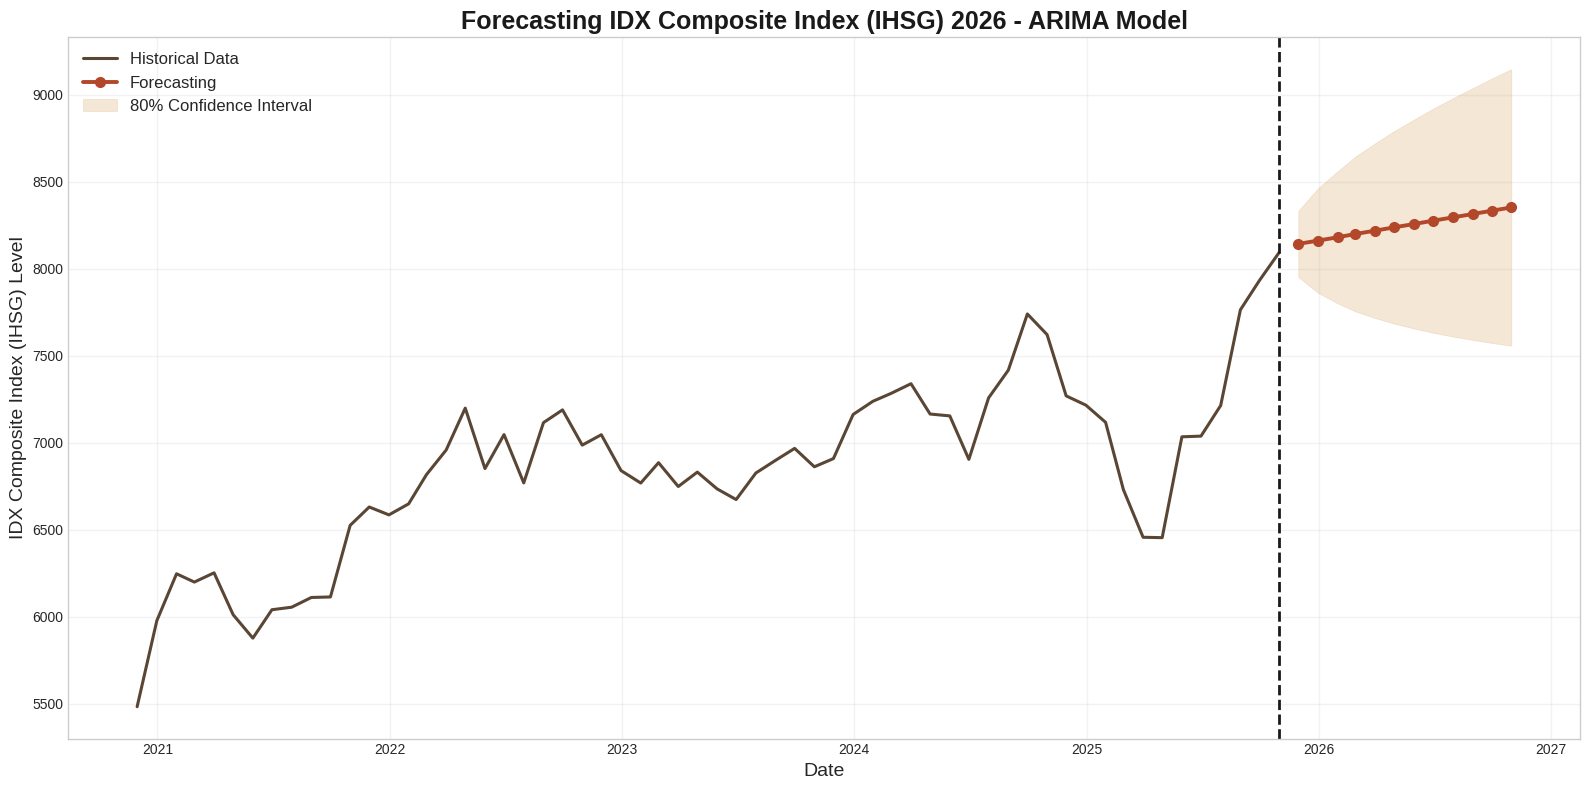

In [98]:
model.update(test)

n_future = 12
forecast_result = model.predict(n_periods=n_future, return_conf_int=True, alpha=0.20)
forecast_mean = forecast_result[0]
forecast_ci = forecast_result[1]

if isinstance(train.index, pd.DatetimeIndex):
    all_data = pd.concat([train, test])
    last_date = all_data.index[-1]
    freq = pd.infer_freq(all_data.index) or 'ME'
    future_index = pd.date_range(start=last_date, periods=n_future+1, freq=freq)[1:]
else:
    future_index = range(len(train) + len(test), len(train) + len(test) + n_future)

forecast_df = pd.DataFrame({
    'forecast': forecast_mean,
    'lower_95': forecast_ci[:, 0],
    'upper_95': forecast_ci[:, 1]
}, index=future_index)

print("\n" + "="*80)
print(f"FORECAST FOR NEXT {n_future} PERIODS")
print("="*80)
print(forecast_df)
print("="*80)

plt.figure(figsize=(16, 8))

color_hist = "#5A4635"
color_fcst = "#B3472A"
color_ci   = "#D8A96C"
color_line = "#1A1A1A"

all_data = pd.concat([train, test]) if isinstance(train, pd.Series) else \
           pd.Series(list(train) + list(test))
hist_length = min(60, len(all_data))

plt.plot(
    all_data.index[-hist_length:],
    all_data[-hist_length:],
    label='Historical Data',
    color=color_hist,
    linewidth=2.2
)

plt.plot(
    forecast_df.index,
    forecast_mean,
    label='Forecasting',
    color=color_fcst,
    linewidth=2.8,
    marker='o',
    markersize=7
)

plt.fill_between(
    forecast_df.index,
    forecast_ci[:, 0],
    forecast_ci[:, 1],
    color=color_ci,
    alpha=0.28,
    label='80% Confidence Interval'
)

plt.axvline(
    x=all_data.index[-1],
    color=color_line,
    linestyle='--',
    linewidth=2
)

plt.title(
    'Forecasting IDX Composite Index (IHSG) 2026 - ARIMA Model',
    fontsize=18,
    fontweight='bold',
    color=color_line
)

plt.xlabel('Date', fontsize=14)
plt.ylabel('IDX Composite Index (IHSG) Level', fontsize=14)

plt.tick_params(axis='both', which='major', labelsize=10)

plt.legend(fontsize=12)
plt.grid(True, alpha=0.25)
plt.tight_layout()

plt.show()


# **ExponentialSmoothing Model (ETS)**

In [75]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [92]:
ets_model = ExponentialSmoothing(
    train,
    trend='add',
    seasonal=None
).fit()

print(ets_model.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Close   No. Observations:                  296
Model:             ExponentialSmoothing   SSE                        3732402.570
Optimized:                         True   AIC                           2802.892
Trend:                         Additive   BIC                           2817.654
Seasonal:                          None   AICC                          2803.183
Seasonal Periods:                  None   Date:                 Tue, 25 Nov 2025
Box-Cox:                          False   Time:                         20:13:28
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            1.0000000                alpha                 True
smoothing_trend             0.0000

### **Model Diagnostics**

In [93]:
residuals = ets_model.resid

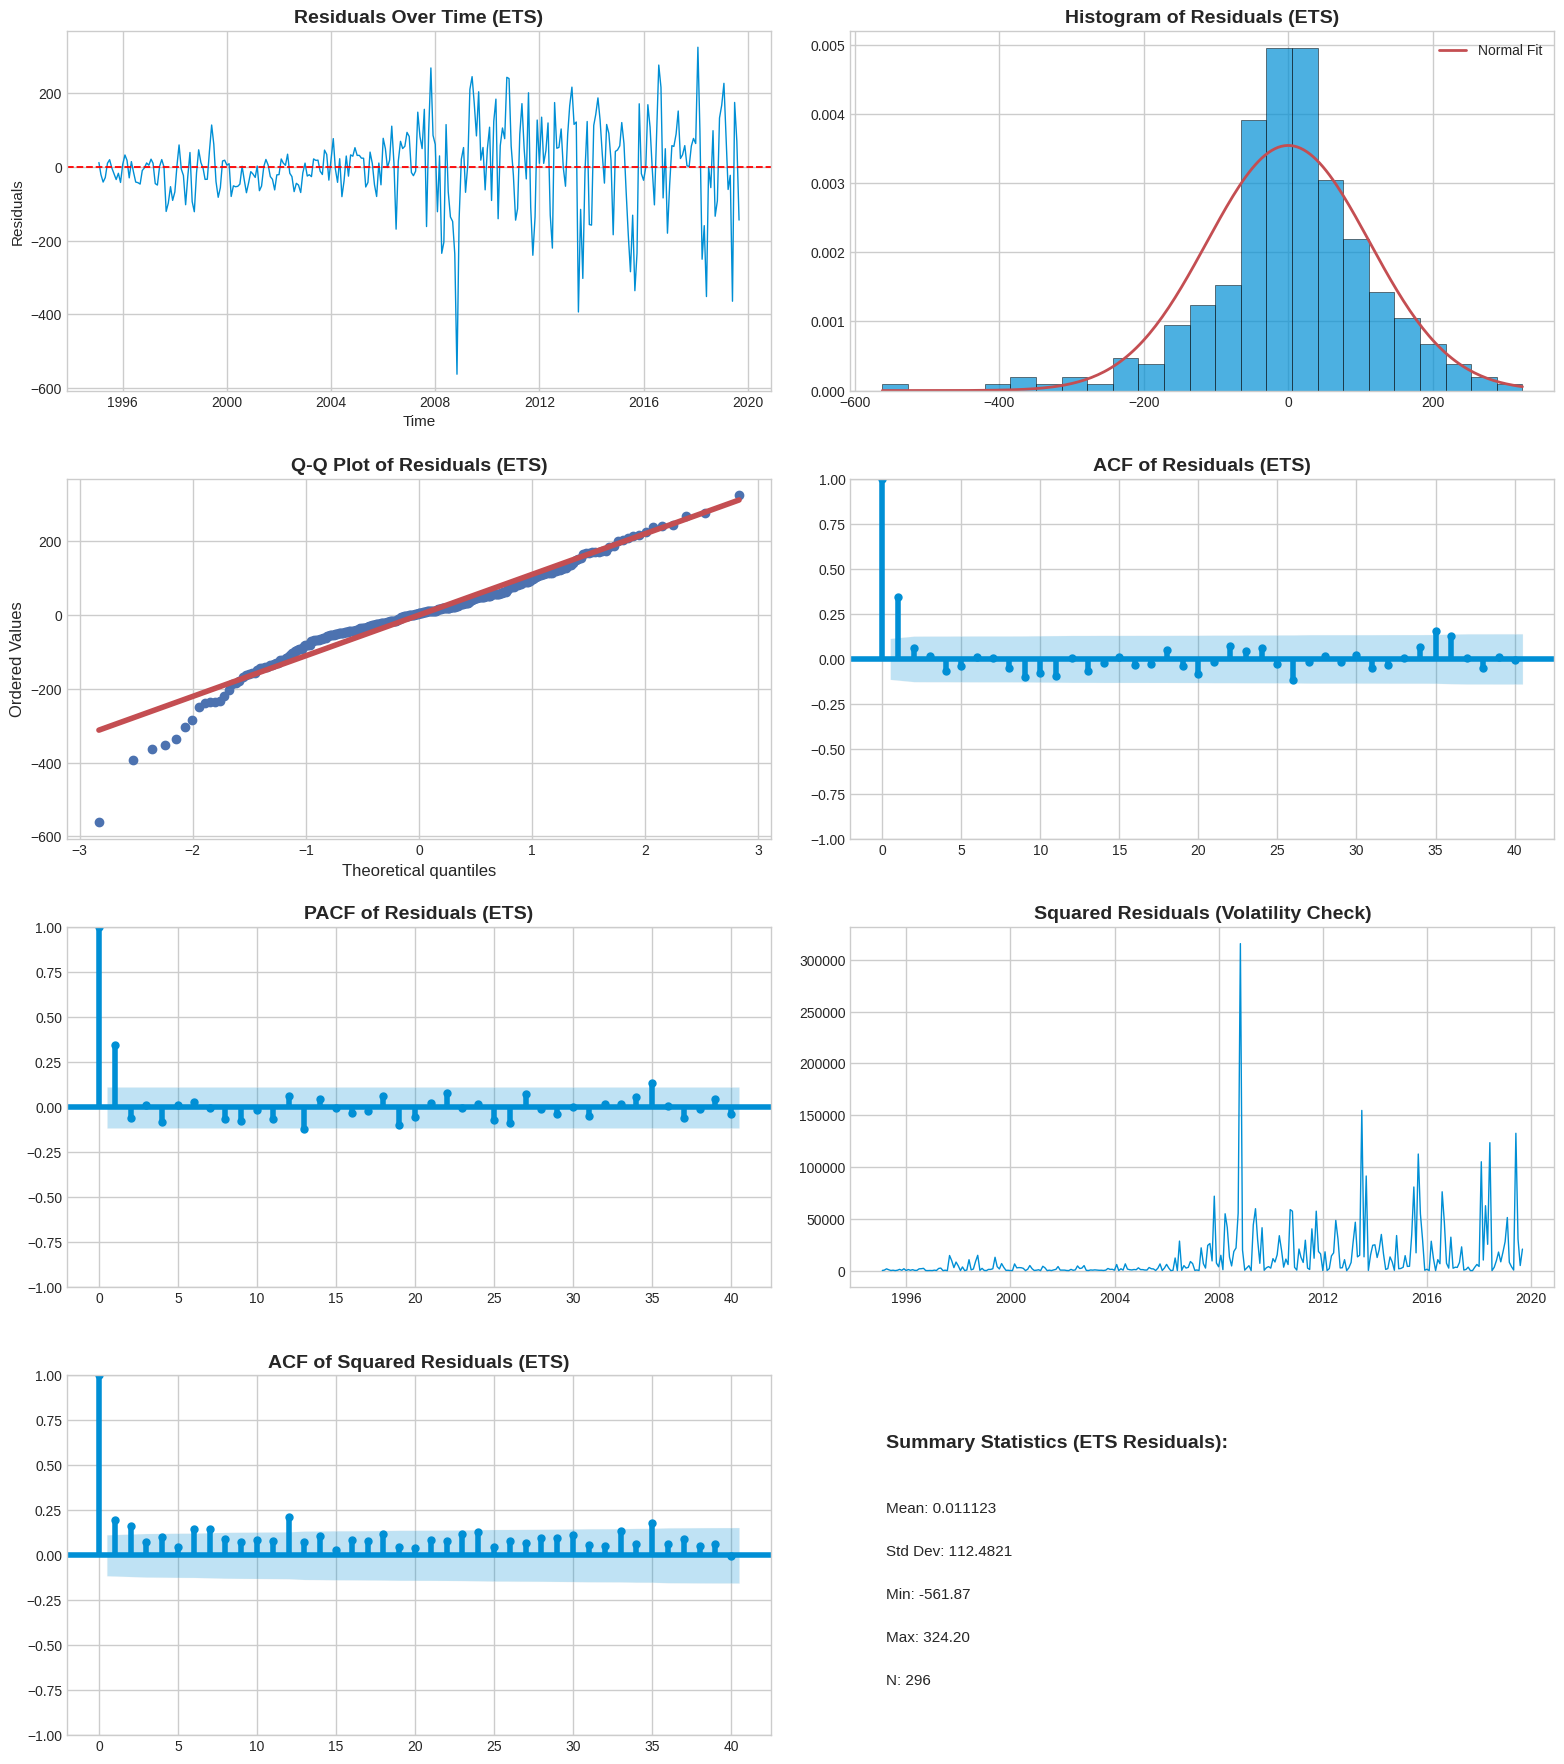

In [94]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import stats

plt.style.use("seaborn-v0_8-whitegrid")

title_size = 14
label_size = 11
tick_size = 10

fig, axes = plt.subplots(4, 2, figsize=(16, 18))
(ax1, ax2, ax3, ax4,
 ax5, ax6, ax7, ax8) = axes.flatten()

ax1.plot(residuals, linewidth=1)
ax1.axhline(0, color='red', linestyle='--', linewidth=1.3)
ax1.set_title("Residuals Over Time (ETS)", fontsize=title_size, weight='bold')
ax1.set_xlabel("Time", fontsize=label_size)
ax1.set_ylabel("Residuals", fontsize=label_size)
ax1.tick_params(axis='both', labelsize=tick_size)

ax2.hist(residuals, bins=25, density=True, alpha=0.7, edgecolor='black')
mu, std = residuals.mean(), residuals.std()
x = np.linspace(residuals.min(), residuals.max(), 200)
ax2.plot(x, stats.norm.pdf(x, mu, std), 'r-', lw=2, label="Normal Fit")
ax2.set_title("Histogram of Residuals (ETS)", fontsize=title_size, weight='bold')
ax2.legend(fontsize=10)
ax2.tick_params(axis='both', labelsize=tick_size)

stats.probplot(residuals, dist="norm", plot=ax3)
ax3.set_title("Q-Q Plot of Residuals (ETS)", fontsize=title_size, weight='bold')
ax3.tick_params(axis='both', labelsize=tick_size)

plot_acf(residuals, lags=40, ax=ax4)
ax4.set_title("ACF of Residuals (ETS)", fontsize=title_size, weight='bold')
ax4.tick_params(axis='both', labelsize=tick_size)

plot_pacf(residuals, lags=40, ax=ax5)
ax5.set_title("PACF of Residuals (ETS)", fontsize=title_size, weight='bold')
ax5.tick_params(axis='both', labelsize=tick_size)

ax6.plot(residuals**2, linewidth=1)
ax6.set_title("Squared Residuals (Volatility Check)", fontsize=title_size, weight='bold')
ax6.tick_params(axis='both', labelsize=tick_size)

plot_acf(residuals**2, lags=40, ax=ax7)
ax7.set_title("ACF of Squared Residuals (ETS)", fontsize=title_size, weight='bold')
ax7.tick_params(axis='both', labelsize=tick_size)

ax8.axis("off")
ax8.text(0.05, 0.80, "Summary Statistics (ETS Residuals):", fontsize=title_size, weight='bold')
ax8.text(0.05, 0.62, f"Mean: {residuals.mean():.6f}", fontsize=label_size)
ax8.text(0.05, 0.50, f"Std Dev: {residuals.std():.4f}", fontsize=label_size)
ax8.text(0.05, 0.38, f"Min: {residuals.min():.2f}", fontsize=label_size)
ax8.text(0.05, 0.26, f"Max: {residuals.max():.2f}", fontsize=label_size)
ax8.text(0.05, 0.14, f"N: {len(residuals)}", fontsize=label_size)

plt.tight_layout(pad=2.0)
plt.show()


### **Model Evaluation**


TEST SET PERFORMANCE (ETS Model)
RMSE: 653.6795
MAE:  467.5080
MAPE: 8.02%


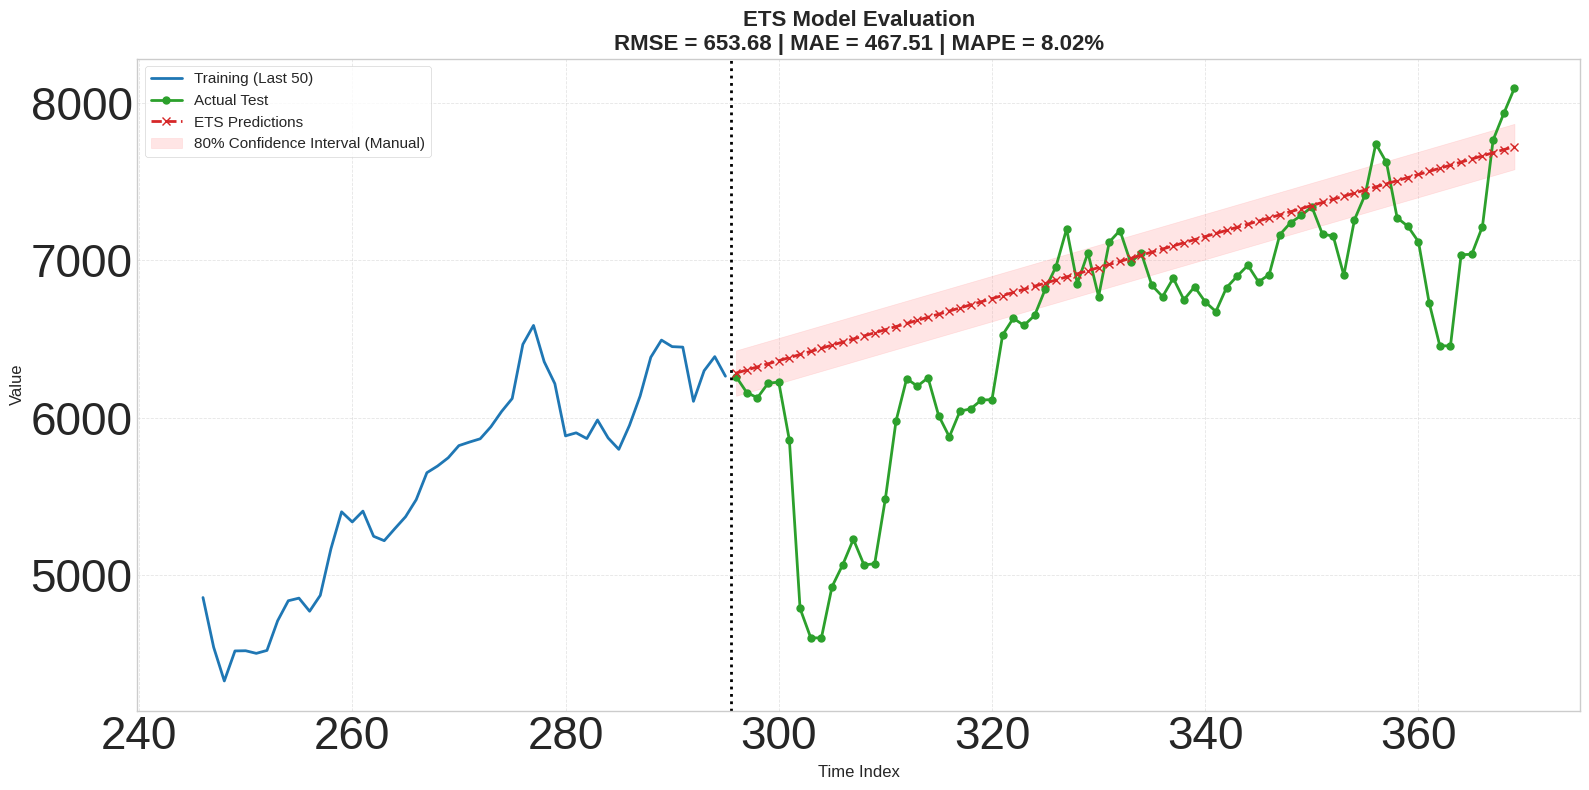

In [96]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

n_periods = len(test)

pred_mean = ets_model.forecast(steps=n_periods)

residuals_ets = ets_model.resid
sigma = residuals_ets.std()

z = norm.ppf(1 - 0.20/2)

lower = pred_mean - z * sigma
upper = pred_mean + z * sigma

rmse = np.sqrt(mean_squared_error(test, pred_mean))
mae = mean_absolute_error(test, pred_mean)
mape = np.mean(np.abs((test - pred_mean) / test)) * 100

print("\n" + "="*80)
print("TEST SET PERFORMANCE (ETS Model)")
print("="*80)
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print("="*80)

plt.figure(figsize=(16, 8))

plt.plot(train_index, train_plot,
         label='Training (Last 50)',
         color='#1f77b4', linewidth=2)

plt.plot(test_index, test,
         label='Actual Test',
         color='#2ca02c', marker='o', markersize=5, linewidth=2)

plt.plot(test_index, pred_mean,
         label='ETS Predictions',
         color='#d62728', linestyle='--', marker='x', markersize=6, linewidth=2)

plt.fill_between(test_index, lower, upper,
                 color='#ff9999', alpha=0.25,
                 label='80% Confidence Interval (Manual)')

plt.axvline(
    x=len(train_index) - 0.5 + (len(train) - 50),
    color='black', linestyle=':', linewidth=2
)

plt.title(
    f"ETS Model Evaluation\nRMSE = {rmse:.2f} | MAE = {mae:.2f} | MAPE = {mape:.2f}%",
    fontsize=16, fontweight='bold'
)

plt.xlabel("Time Index", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.legend(frameon=True, fontsize=11)
plt.grid(True, linestyle='--', linewidth=0.6, alpha=0.5)

plt.tight_layout()
plt.show()


### **Forecasting**


FORECAST FOR NEXT 12 PERIODS (ETS)
               forecast     lower_95     upper_95
2025-11-30  8113.999384  7923.391645  8304.607123
2025-12-31  8134.724356  7944.116617  8325.332094
2026-01-31  8155.449328  7964.841589  8346.057066
2026-02-28  8176.174300  7985.566561  8366.782038
2026-03-31  8196.899272  8006.291533  8387.507010
2026-04-30  8217.624243  8027.016505  8408.231982
2026-05-31  8238.349215  8047.741477  8428.956954
2026-06-30  8259.074187  8068.466449  8449.681926
2026-07-31  8279.799159  8089.191421  8470.406898
2026-08-31  8300.524131  8109.916392  8491.131870
2026-09-30  8321.249103  8130.641364  8511.856842
2026-10-31  8341.974075  8151.366336  8532.581814


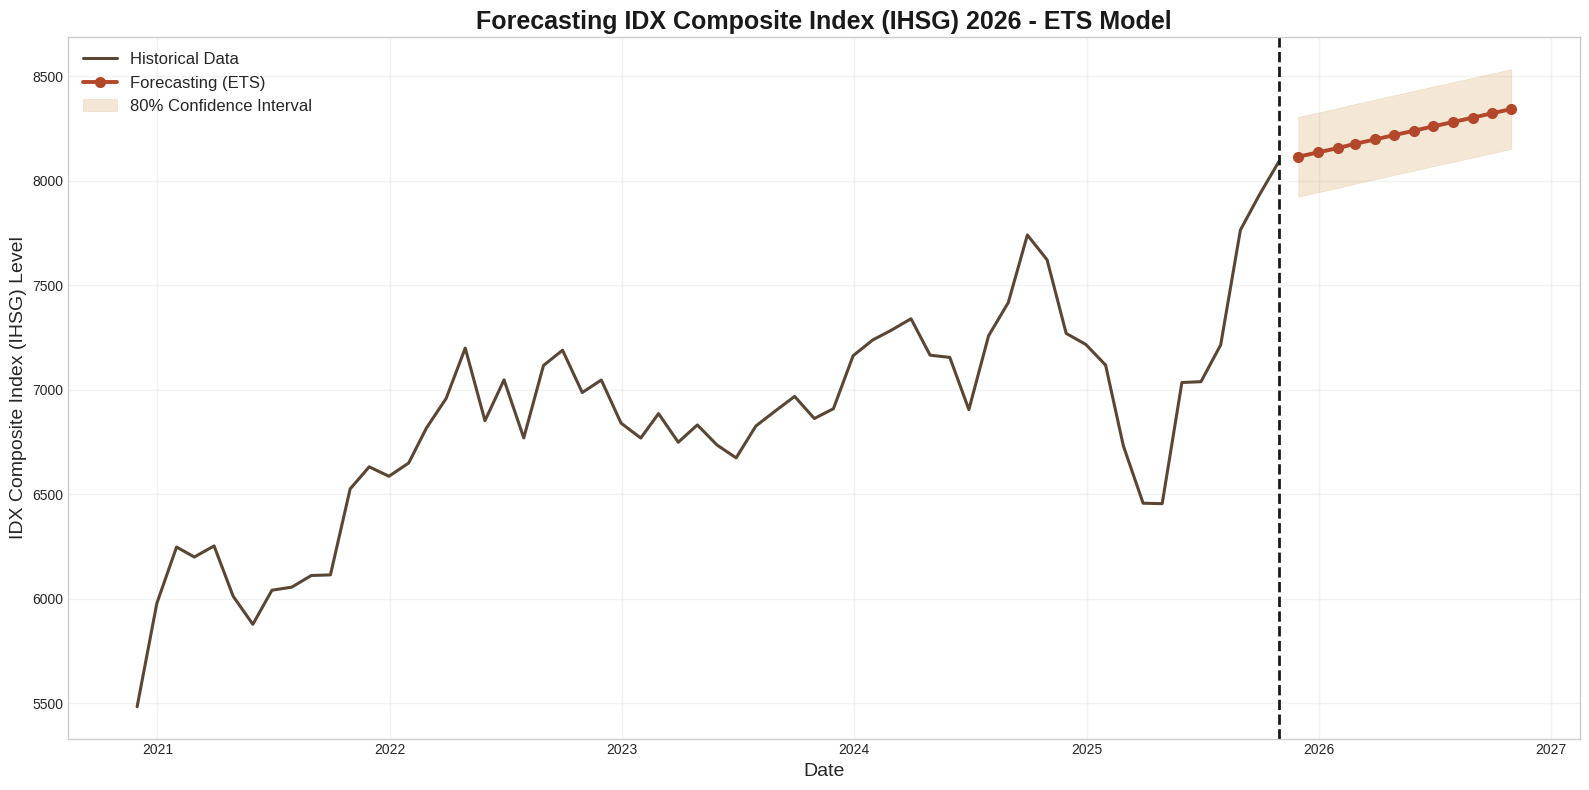

In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

ets_model_full = ExponentialSmoothing(
    pd.concat([train, test]),
    trend='add',
    seasonal=None,
).fit()

n_future = 12
forecast_mean = ets_model_full.forecast(n_future)

residuals_ets = ets_model.resid
sigma = residuals_ets.std()

z = norm.ppf(1 - 0.20/2)

lower_95 = forecast_mean - z * resid_std
upper_95 = forecast_mean + z * resid_std

if isinstance(train.index, pd.DatetimeIndex):
    all_data = pd.concat([train, test])
    last_date = all_data.index[-1]
    freq = pd.infer_freq(all_data.index) or 'D'
    future_index = pd.date_range(
        start=last_date,
        periods=n_future + 1,
        freq=freq
    )[1:]
else:
    future_index = range(len(train) + len(test),
                         len(train) + len(test) + n_future)

forecast_df = pd.DataFrame({
    'forecast': forecast_mean.values,
    'lower_95': lower_95.values,
    'upper_95': upper_95.values
}, index=future_index)

print("\n" + "="*80)
print(f"FORECAST FOR NEXT {n_future} PERIODS (ETS)")
print("="*80)
print(forecast_df)
print("="*80)

plt.figure(figsize=(16, 8))

color_hist = "#5A4635"
color_fcst = "#B3472A"
color_ci   = "#D8A96C"
color_line = "#1A1A1A"

all_data = pd.concat([train, test])
hist_length = min(60, len(all_data))

plt.plot(
    all_data.index[-hist_length:],
    all_data[-hist_length:],
    label='Historical Data',
    color=color_hist,
    linewidth=2.2
)

plt.plot(
    forecast_df.index,
    forecast_df['forecast'],
    label='Forecasting (ETS)',
    color=color_fcst,
    linewidth=2.8,
    marker='o',
    markersize=7
)

plt.fill_between(
    forecast_df.index,
    forecast_df['lower_95'],
    forecast_df['upper_95'],
    color=color_ci,
    alpha=0.28,
    label='80% Confidence Interval'
)

plt.axvline(
    x=all_data.index[-1],
    color=color_line,
    linestyle='--',
    linewidth=2
)

plt.title(
    'Forecasting IDX Composite Index (IHSG) 2026 - ETS Model',
    fontsize=18,
    fontweight='bold',
    color=color_line
)

plt.xlabel('Date', fontsize=14)
plt.ylabel('IDX Composite Index (IHSG) Level', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()


# **Discussion**

To compare the two models, the most efficient method is to compare evaluation metrics, namely comparing the RMSE, MAE, and MAPE values between the ARIMA and ETS models. Lower RMSE, MAE, and MAPE values indicate better forecasting accuracy (Zhang, 2024).

**1. ARIMA Model Performance**

- RMSE: 622.1699
- MAE:  434.6055
- MAPE: 7.48%

**2. ETS Model Performance**

- RMSE: 653.6795
- MAE:  467.5080
- MAPE: 8.02%

Based on the metric results from both models, the ARIMA model value is better than the ETS model value by a small difference. This means the ARIMA model is better at predicting or forecasting.



# **Limitations**

The Time Series method has limitations in performing analysis, including the following:

- It only looks at **Linear Relationships** and cannot see more complex relationships.
- It can only analyze one variable, known as **Univariate**, so other factors such as interest rates, GDP, exchange rates, and other macroeconomic factors cannot be included.

# **References**

Zhang, H. (2024). Time-Series Analysis and Forecasting of S&P500 Index Based on ARIMA and ETS Model. Highlights in Business, Economics and Management, 24, 306-316. [https://doi.org/10.54097/anhgak96](https://doi.org/10.54097/anhgak96)

